<a href="https://colab.research.google.com/github/pietrodileo/Python_for_MD_thesis/blob/main/CNN_CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2

# !pip install tensorflow==2.8
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)
from PIL import Image
from scipy import misc
import sklearn
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# DEEP LEARNING IMPORTS
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wave
import pylab
import sys
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
import itertools
import time
import shutil
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Unzip Directory

In [ ]:
local_path = '/content'
name = '/content/C1';
zipfile = name+'.zip'
!unzip -q '{zipfile}'
NewDir = os.path.join(local_path,name)

replace C1/class_advanced_PD-OFF/PD_OFF_TesiPDL_VowelE_0001_FineCut_Short_FreqMasked.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Extract image path

In [ ]:
valid_formats = [".png"]
pathlist = []
classnames = []
labVec = []
istanceVec = []
lablist = []
#dataclass = []
#dataAll = []
for folders in os.listdir(NewDir):
  # select a subfolder
  subfolder = os.path.join(NewDir,folders)
  # select all the records in the subfolder
  print('reading folder: '+ subfolder)
  subfolderList = []
  subfolderlabel = []
  pathVec = []
  for filename in os.listdir(subfolder):
    file_format = os.path.splitext(filename)[1] 
    if file_format.lower() in valid_formats:
      subfolderList.append(filename)
      currClass = os.path.split(subfolder)[1]
      labVec.append(currClass)
      istanceVec.append(filename)
      # extract file path
      pathVec.append(os.path.join(subfolder,filename))
      subfolderlabel.append(currClass)

  pathlist.append(pathVec)
  lablist.append(subfolderlabel)
  classnames.append(currClass)

reading folder: /content/C1/class_advanced_PD-OFF
reading folder: /content/C1/class_HealthyControl


In [ ]:
pathColumns = pd.DataFrame(pathlist)
pathColumns = pathColumns.transpose()
pathColumns.columns = classnames
pathColumns.head(5)

,class_advanced_PD-OFF,class_HealthyControl
0,/content/C1/class_advanced_PD-OFF/PD_OFF_TesiP...,/content/C1/class_HealthyControl/HC_TesiPDL_Vo...
1,/content/C1/class_advanced_PD-OFF/PD_OFF_TesiP...,/content/C1/class_HealthyControl/HC_TesiPDL_Vo...
2,/content/C1/class_advanced_PD-OFF/PD_OFF_TesiP...,/content/C1/class_HealthyControl/HC_TesiPDL_Vo...
3,/content/C1/class_advanced_PD-OFF/PD_OFF_TesiP...,/content/C1/class_HealthyControl/HC_TesiPDL_Vo...
4,/content/C1/class_advanced_PD-OFF/PD_OFF_TesiP...,/content/C1/class_HealthyControl/HC_TesiPDL_Vo...


In [ ]:
labColumns = pd.DataFrame(lablist)
labColumns = labColumns.transpose()
labColumns.columns = classnames
labColumns.head(2)

,class_advanced_PD-OFF,class_HealthyControl
0,class_advanced_PD-OFF,class_HealthyControl
1,class_advanced_PD-OFF,class_HealthyControl


In [ ]:
dictionary = {'Istance': istanceVec,'Class': labVec}
classVec = pd.DataFrame(data = dictionary)
classVec.head(4)

,Istance,Class
0,PD_OFF_TesiPDL_VowelE_0088_1_FineCut_Short_Str...,class_advanced_PD-OFF
1,PD_OFF_TesiPDL_VowelE_0050_FineCut_Short_Time_...,class_advanced_PD-OFF
2,PD_OFF_TesiPDL_VowelE_0013_FineCut_Short_Stret...,class_advanced_PD-OFF
3,PD_OFF_TesiPDL_VowelE_0039_FineCut_Short_Time_...,class_advanced_PD-OFF


# Split in K-Folds

Dividiamo ogni colonna di labColumns in K gruppi diversi. Divideremo ogni colonna con la stessa percentuale di split, così da essere sicuri di avere in ogni folder lo stesso numero di soggetti per ogni classe

In [ ]:
from sklearn.model_selection import KFold
# perform crossvalidation
k = 10 
testPath = []
y_trainClass = []
y_testClass = []
kfoldClass = []
splittedData = []
for i in range(0,len(classnames)):
  # define crossvalidation object
  kf = KFold(n_splits = k, shuffle = True, random_state = np.random.randint(1, 100))
  kfoldClass = []
  # take the current class vector
  currentClassVector = labColumns[classnames[i]]
  currentClassVector = currentClassVector.dropna()
  #print('Class: ', classnames[i])
  # split train and test set for each class
  for train_index , test_index in kf.split(currentClassVector):
    #print('train=', train_index, 'test=', test_index)
    trainPathClass = pathColumns[classnames[i]][train_index]
    testPathClass = pathColumns[classnames[i]][test_index]
    y_trainClass = labColumns[classnames[i]][train_index]
    y_testClass = labColumns[classnames[i]][test_index]
    # define dataframe for test and training for the current class
    dictionClassTrain = {'Path': trainPathClass,'Class': y_trainClass}
    dictionClassTest = {'Path': testPathClass,'Class': y_testClass}
    dfPathTest = pd.DataFrame(data = dictionClassTest)
    dfPathTrain = pd.DataFrame(data = dictionClassTrain)
    # make a tuple for the current folder (k) of the current class (i)
    kfoldTuple = (dfPathTest,dfPathTrain)
    # kfoldClass is a list containing k tuple regarding the i-th class
    kfoldClass.append(kfoldTuple)
  # splittedData is a list containing a list for each class (the latter contains k tuple)
  splittedData.append(kfoldClass)

Create Train Set and Test Set

In [ ]:
TrainSet = []
TestSet = []
TrainPath = []
TestPath = []
TestPath1 = []
TrainPath1 = []
for i in range(0,k):
  for j in range(0,len(classnames)):
    # take the current class (list of k tuple)
    currClass = splittedData[j]
    # take the tuple regarding the k-th folder
    kfold = currClass[i]
    dfPathTest = kfold[0]
    dfPathTrain = kfold[1] 
    # for the first class
    if j == 0:
      TestPath1 = dfPathTest
      TrainPath1 = dfPathTrain
    # next classes
    elif j > 0:
      TestPath = pd.concat([TestPath1, dfPathTest],ignore_index=True)
      TrainPath = pd.concat([TrainPath1, dfPathTrain],ignore_index=True)
  # shuffle all the rows of train data 
  TrainPath = TrainPath.sample(frac=1)
  # save training set and test set for all the K-folders
  TrainSet.append(TrainPath)
  TestSet.append(TestPath)

# Get the train and test data

In [ ]:
from tqdm import tqdm 

#A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images,nrows,ncolumns):
    """
    Returns X: 
        X is an array of resized images
    """    
    X = [] # images
    
    # Store all the images in the variable X
    for image in tqdm(list_of_images):
        X.append(cv2.resize(cv2.imread(image, cv2.COLOR_BGR2GRAY), 
                            (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
    
    return X

Extract train and test set from column k

In [ ]:
fold = 0
# copy the image from the path to another directory
ImageList = TrainSet[fold]['Path']
ImageLabel = TrainSet[fold]['Class']
ImageListTest = TestSet[fold]['Path']
ImageLabelTest = TestSet[fold]['Class']

newfolderpath = os.path.join(local_path,'newFolder')
if not os.path.exists(newfolderpath):
   # Create a new directory because it does not exist
   os.makedirs(newfolderpath)
   print("New folder has been created!")
testsubfolder = os.path.join(newfolderpath,'Test')
trainsubfolder = os.path.join(newfolderpath,'Training')
os.makedirs(trainsubfolder)
os.makedirs(testsubfolder)
print("Subfolders have been created!")

Subfolders have been created!


Copy each image from the original folder to a new one (divided in subfolders representing each class)

In [ ]:
import shutil
def CopyFile(dstn_subfolder, imageseries):
  for originalFilePath in imageseries:
    file_format = os.path.splitext(originalFilePath)[1] 
    filename = os.path.splitext(originalFilePath)[0] 
    fileclass = os.path.split(filename)[0]
    fileclass = os.path.split(fileclass)[1]
    filename = os.path.split(filename)[1]
    newfileFolder = os.path.join(dstn_subfolder,fileclass)
    if not os.path.exists(newfileFolder):
      # Create a new directory because it does not exist
      os.makedirs(newfileFolder)
      print("New folder has been created!")
    newFilePath = os.path.join(dstn_subfolder,fileclass,filename)
    newFilePath = newFilePath+file_format
    shutil.copy2(originalFilePath, newFilePath, follow_symlinks=True)

CopyFile(trainsubfolder, ImageList)
CopyFile(testsubfolder, ImageListTest)

New folder has been created!
New folder has been created!


CNN

In [ ]:
#@title Declare Constants
#@markdown ---
fileName = 'C18' #@param {type: "string"}
num_cnn_layers = 4 #@param {type: "number"}
IMAGE_HEIGHT = 256 #@param {type: "number"}
IMAGE_WIDTH = 256 #@param {type: "number"}
BATCH_SIZE = 32 #@param {type: "slider", min: 1, max: 256}
EPOCHS = 100  #@param {type: "number"}
VAL_SPLIT = 0.2  #@param {type: "slider", min: 0, max: 1, step:0.05}
MODE = "grayscale"  #@param ['rgb', 'rgba', 'grayscale']
SaveFile = True #@param {type: "boolean"}
#@markdown ---

In [ ]:
# Function to prepare our datasets for modelling
def prepare(batches):

  def normalize(img, label):
    return img / 255.0, label

  ds = (batches
        .map(normalize)
        .prefetch(tf.data.AUTOTUNE)
        ) 
  return ds

# Select number of channels
if MODE == 'grayscale':
  N_CHANNELS = 1
elif MODE == 'rgb':
  N_CHANNELS = 3
elif MODE == 'rgba':
  N_CHANNELS = 4

# Create the dataset and select number of classes
train_batches = train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            trainsubfolder,
                                            labels='inferred',
                                            class_names = False,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            color_mode= MODE,
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            seed=0)
# Create the dataset and select number of classes
test_batches = train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            testsubfolder,
                                            labels='inferred',
                                            class_names = False,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            color_mode= MODE,
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            seed=0)


classNames = train_batches.class_names
N_CLASSES = len(classNames)

# Extract image path for training and validation set
image_paths_train = train_batches.file_paths
image_paths_valid = test_batches.file_paths

train_dataset = prepare(train_batches)
valid_dataset = prepare(test_batches)

LabelNames = test_batches.class_names
LabelNames

Found 1072 files belonging to 2 classes.
Found 120 files belonging to 2 classes.


['class_HealthyControl', 'class_advanced_PD-OFF']

In [ ]:
def make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES, num_cnn_layers):
  # Create CNN model with 3 Convolution Layer Architecture
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
  # Conv2D(NumFilter, FilterSize, option...)

  NUM_FILTERS = 32
  for i in range(1, num_cnn_layers+1):
    model.add(tf.keras.layers.Conv2D(NUM_FILTERS*i, (3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

  # flattening
  model.add(tf.keras.layers.Flatten())
  # NN 
  model.add(tf.keras.layers.Dense(256, activation='relu')) 
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
  return model

In [ ]:
monitorValue = 'val_loss'
monitorMode = 'min'

checkpoint_path = os.path.join(outputPath,'training_1/cp.ckpt')
bestModelName = os.path.join(outputPath,'best_mdl.h5')
earlyStopping = EarlyStopping(monitor=monitorValue, 
                              patience=40, 
                              verbose=0, 
                              mode=monitorMode,
                              restore_best_weights=True)

mcp_save = ModelCheckpoint(filepath=checkpoint_path,
                           save_best_only=True, 
                           monitor=monitorValue, 
                           mode=monitorMode)

reduce_lr_loss = ReduceLROnPlateau(monitor=monitorValue,
                                   factor=0.1, patience=5, 
                                   verbose=0, min_delta=1e-4, mode=monitorMode)

LOSS = 'sparse_categorical_crossentropy'

# OPTIMIZER = tf.keras.optimizers.SGD(
#         learning_rate=0.01,
#         momentum=0.0,
#         nesterov=False,
#         name='SGD')

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
model = make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES, num_cnn_layers)
# Compile model
model.compile(
    loss = LOSS,
    optimizer = OPTIMIZER,
    metrics=['accuracy'])

In [ ]:
# Train model and capture the history
history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data = valid_dataset,
                    #callbacks = [earlyStopping, mcp_save, reduce_lr_loss]
                    )

Epoch 1/100
 2/34 [>.............................] - ETA: 3:27 - loss: 1.2956 - accuracy: 0.6250

KeyboardInterrupt: ignored

In [ ]:
nrows = 256
ncolumns = 256
fold = 0
ImageList = TrainSet[fold]['Path']
ImageLabel = TrainSet[fold]['Class']
TrainImages = read_and_process_image(ImageList, nrows, ncolumns)

ImageListTest = TestSet[fold]['Path']
ImageLabelTest = TestSet[fold]['Class']
TestImages = read_and_process_image(ImageListTest, nrows, ncolumns)

100%|██████████| 120/120 [00:02<00:00, 44.89it/s]


100%|██████████| 5/5 [00:00<00:00, 56.11it/s]


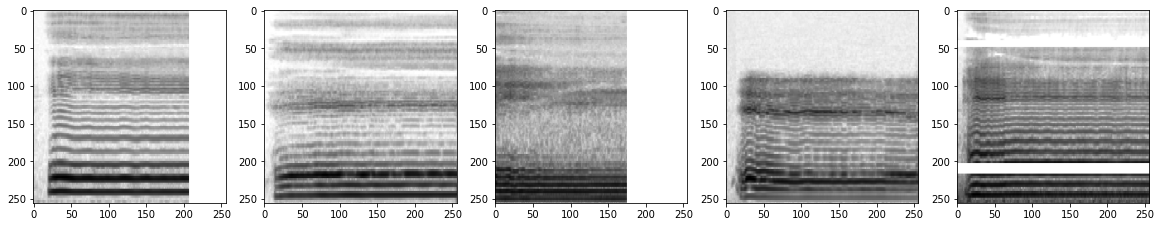

In [ ]:
#Lets view some of the pics
plt.figure(figsize=(20,10))
columns = 5
for i in tqdm(range(columns)):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(TrainImages[i])

Check if data are correct

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Labels')

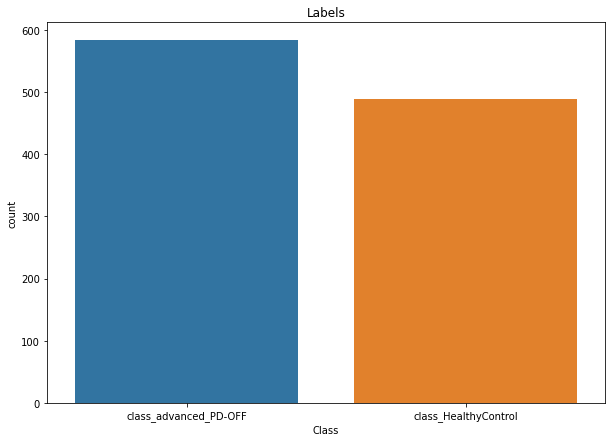

In [ ]:
import seaborn as sns
#Lets plot the label to be sure we just have two class
sns.countplot(ImageLabel)
plt.title('Labels')

In [ ]:
#Convert list to numpy array
TrainImages = np.array(TrainImages)
TestImages = np.array(TestImages)

batch_size = 32

# CNN

In [ ]:
#@title Declare Constants
#@markdown ---
fileName = 'C18' #@param {type: "string"}
num_cnn_layers = 4 #@param {type: "number"}
IMAGE_HEIGHT = 256 #@param {type: "number"}
IMAGE_WIDTH = 256 #@param {type: "number"}
BATCH_SIZE = 32 #@param {type: "slider", min: 1, max: 256}
EPOCHS = 100  #@param {type: "number"}
VAL_SPLIT = 0.2  #@param {type: "slider", min: 0, max: 1, step:0.05}
MODE = "grayscale"  #@param ['rgb', 'rgba', 'grayscale']
SaveFile = True #@param {type: "boolean"}
#@markdown ---

In [ ]:
TASK = str(EPOCHS) + 'EP_' + str(num_cnn_layers) + 'conv_' + 'Batch' + str(BATCH_SIZE) + '_adam_' + fileName  
TASK

'100EP_4conv_Batch32_adam_C18'

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout , Activation, Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import applications 
#from tensorflow.keras.utils import to_categorical 

In [ ]:
def make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES, num_cnn_layers):
  # Create CNN model with 3 Convolution Layer Architecture
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
  # Conv2D(NumFilter, FilterSize, option...)
 
  NUM_FILTERS = 32
  for i in range(1, num_cnn_layers+1):
    model.add(tf.keras.layers.Conv2D(NUM_FILTERS*i, (3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

  # flattening
  model.add(tf.keras.layers.Flatten())
  # NN 
  model.add(tf.keras.layers.Dense(256, activation='relu')) 
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
  return model

In [ ]:
# Select number of channels
if MODE == 'grayscale':
  N_CHANNELS = 1
elif MODE == 'rgb':
  N_CHANNELS = 3
elif MODE == 'rgba':
  N_CHANNELS = 4

# Create the dataset and select number of classes
N_CLASSES = len(pathlist)

In [ ]:
model = make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES, num_cnn_layers)
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
LOSS = 'sparse_categorical_crossentropy'
model.compile(
    loss = LOSS,
    optimizer = OPTIMIZER,
    metrics=['accuracy'])

Preprocessing Data

In [ ]:
#Scale the image between 0 and 1
train_datagen = ImageDataGenerator(rescale=1./255)   
val_datagen = ImageDataGenerator(rescale=1./255) 

In [ ]:
from sklearn.preprocessing import LabelEncoder

def createNumericalVariable(categoricalVariable):
  # create dummy variables
  labelDummy = pd.get_dummies(categoricalVariable)
  labelDummy.columns = list(range(0, len(labelDummy.columns)))
  # reverseDummy: change class labeling to 0 and 1
  ClassNumerical = pd.DataFrame(labelDummy.idxmax(axis=1))
  ClassNumerical.columns = ['Class']
  # convert dataframe to series
  ClassNumerical = ClassNumerical.squeeze()
  return ClassNumerical

ClassNumerical = createNumericalVariable(ImageLabel)
ClassNumericalTest = createNumericalVariable(ImageLabelTest)

#Create the image generators
train_generator = train_datagen.flow(TrainImages, ClassNumerical, batch_size=batch_size)
val_generator = val_datagen.flow(TestImages, ClassNumericalTest, batch_size=batch_size)

In [ ]:
#get the length of the train and validation data
ntrain = len(TrainImages)
nval = len(TestImages)

In [ ]:
# Train model and capture the history
history = model.fit(train_generator, 
                    epochs=5, 
                    validation_data = val_generator)

Epoch 1/5


UnimplementedError: ignored

Utility Functions

In [ ]:
#one hot encoding function
def one_hot_encoder(df_name, df_column_name, suffix=''):
    temp = pd.get_dummies(df_name[df_column_name]) #get dummies is used to create dummy columns
    df_name = df_name.join(temp, lsuffix=suffix) #join the newly created dummy columns to original dataframe
    df_name = df_name.drop(df_column_name, axis=1) #drop the old column used to create dummy columnss
    return df_name


#function to draw confusion matrix
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
    plt.show()
    #return conf_matx

Split into train adn test set

In [ ]:
# train_x, test_x, train_y, test_y = train_test_split(train_x_scaled, train_images_y_encoded, random_state = 101, 
#                                                    test_size=0.25)

Defining the CNN Architecture

In [ ]:
def cnn_model(size, num_cnn_layers):
    NUM_FILTERS = 32
    KERNEL = (3, 3)
    #MIN_NEURONS = 20
    MAX_NEURONS = 120
    
    model = Sequential()
    
    for i in range(1, num_cnn_layers+1):
        if i == 1:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, input_shape=size, activation='relu', padding='same'))
        else:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(int(MAX_NEURONS), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(int(MAX_NEURONS/2), activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #print(model.summary())
    
    return model

In [ ]:
model = cnn_model(IMAGE_SIZE, 2)

In [ ]:
model.summary()

Define some callbacks 

In [ ]:
#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = cnn_model(IMAGE_SIZE, 2)
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

Train the model with K-fold Cross Val

In [ ]:
n_folds=3
epochs=20
batch_size=128

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(train_x, train_y, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1


2022-11-19 18:11:10.252232: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-19 18:11:12.483286: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


285/285 [==============================] - 12s 10ms/step - loss: 0.5633 - accuracy: 0.7967 - val_loss: 0.3488 - val_accuracy: 0.8726

Epoch 00001: val_loss improved from inf to 0.34877, saving model to fas_mnist_1.h5
Epoch 2/20
285/285 [==============================] - 3s 9ms/step - loss: 0.3350 - accuracy: 0.8811 - val_loss: 0.2977 - val_accuracy: 0.8923

Epoch 00002: val_loss improved from 0.34877 to 0.29766, saving model to fas_mnist_1.h5
Epoch 3/20
285/285 [==============================] - 3s 9ms/step - loss: 0.2785 - accuracy: 0.9001 - val_loss: 0.2716 - val_accuracy: 0.9030

Epoch 00003: val_loss improved from 0.29766 to 0.27164, saving model to fas_mnist_1.h5
Epoch 4/20
285/285 [==============================] - 3s 9ms/step - loss: 0.2363 - accuracy: 0.9128 - val_loss: 0.2506 - val_accuracy: 0.9128

Epoch 00004: val_loss improved from 0.27164 to 0.25060, saving model to fas_mnist_1.h5
Epoch 5/20
285/285 [==============================] - 3s 9ms/step - loss: 0.2064 - accuracy: 

Plots to see how the models are performing

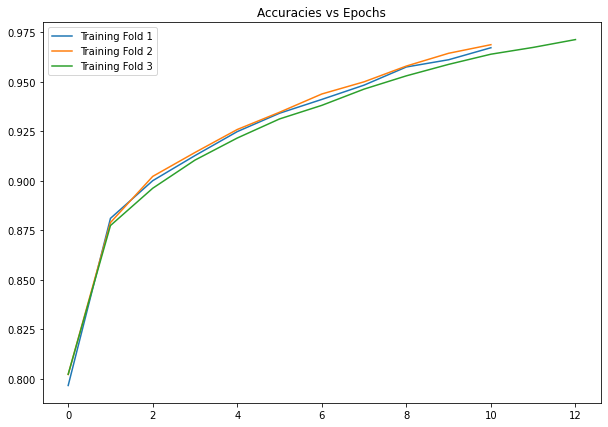

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

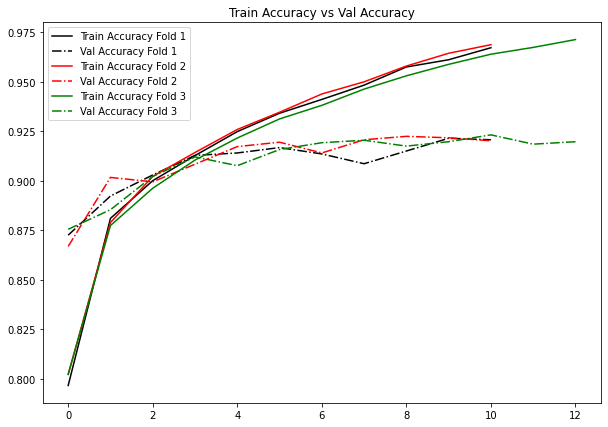

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

Test the score on the test split

In [ ]:
#Load the model that was saved by ModelCheckpoint
model = load_model('fas_mnist_1.h5')

In [ ]:
model.evaluate(test_x, test_y)

469/469 [==============================] - 2s 3ms/step - loss: 0.2318 - accuracy: 0.9200


[0.23181605339050293, 0.9200000166893005]

Check scoring on the actual test set

In [ ]:
model.evaluate(test_x_scaled, test_images_y_encoded)

313/313 [==============================] - 1s 3ms/step - loss: 0.2234 - accuracy: 0.9198


[0.22341938316822052, 0.9197999835014343]

In [ ]:
#function for converting predictions to labels
def prep_submissions(preds_array, file_name='abc.csv'):
    preds_df = pd.DataFrame(preds_array)
    predicted_labels = preds_df.idxmax(axis=1) #convert back one hot encoding to categorical variabless
    return predicted_labels
    '''
    ### prepare submissions in case you need to submit
    submission = pd.read_csv("test.csv")
    submission['label'] = predicted_labels
    submission.to_csv(file_name, index=False)
    print(pd.read_csv(file_name).head())
    '''

In [ ]:
test_preds = model.predict(test_x_scaled)
test_preds_labels = prep_submissions(test_preds)

In [ ]:
print(classification_report(test_images_y, test_preds_labels))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1000
           1       0.99      0.99      0.99      1000
           2       0.91      0.86      0.89      1000
           3       0.92      0.93      0.93      1000
           4       0.90      0.89      0.89      1000
           5       0.97      0.98      0.98      1000
           6       0.77      0.78      0.77      1000
           7       0.98      0.93      0.95      1000
           8       0.97      0.99      0.98      1000
           9       0.94      0.98      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



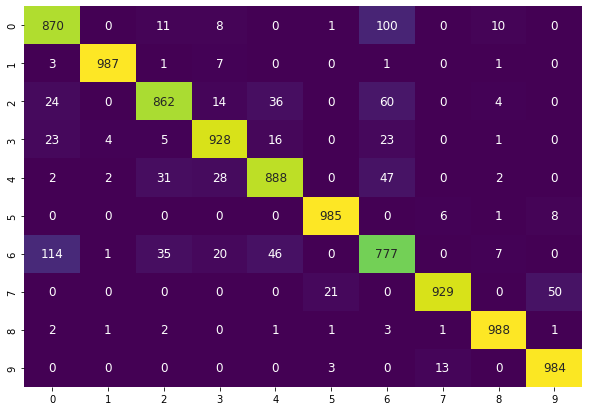

In [ ]:
draw_confusion_matrix(test_images_y, test_preds_labels)